# Proyecto Integrador - Módulo 2: Clasificación de Sonidos Cardiacos y Pulmonares

## 1. Introducción

### Contexto del Problema
La detección temprana de anomalías cardiacas (como soplos) y pulmonares (como sibilancias o crepitaciones) es fundamental para el diagnóstico clínico. Sin embargo, la auscultación depende en gran medida de la experiencia del médico. El uso de Inteligencia Artificial para el procesamiento de señales de audio permite objetivizar y automatizar esta tarea, proporcionando una herramienta de apoyo al diagnóstico.

### Objetivo
Desarrollar un modelo de aprendizaje automático (Random Forest) capaz de clasificar a partir de características de audio (MFCCs) si una grabación corresponde a un sonido normal o a una patología específica, utilizando un dataset de 535 grabaciones capturadas de un maniquí clínico.

### Justificación de la Técnica
Se utiliza la técnica de **Clasificación Supervisada**. Las señales de audio se transforman en **MFCCs (Mel-Frequency Cepstral Coefficients)**, que capturan las características espectrales del sonido de manera similar a como el oído humano percibe las frecuencias. El modelo **Random Forest** es ideal para este dataset por su robustez ante el ruido y su capacidad para manejar múltiples clases con un número moderado de muestras.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURACIÓN ---
FILE_HS_CSV = 'HS.csv'
FILE_LS_CSV = 'LS.csv'
FILE_MIX_CSV = 'Mix.csv'

DIR_HS = os.path.join('HS', 'HS')
DIR_LS = os.path.join('LS', 'LS')
DIR_MIX = os.path.join('Mix', 'Mix')

## 2. Carga y Preparación de Datos
Ingestamos los datos de las tres fuentes disponibles: Sonidos Cardiacos (HS), Pulmonares (LS) y las fuentes del dataset Mezclado (Mix).

In [8]:
def load_datasets():
    data = []
    # 1. HS
    if os.path.exists(FILE_HS_CSV):
        df_hs = pd.read_csv(FILE_HS_CSV)
        for _, row in df_hs.iterrows():
            data.append({'path': os.path.join(DIR_HS, f"{row['Heart Sound ID']}.wav"), 
                         'label': f"Heart_{row['Heart Sound Type']}", 'type': 'Heart'})
    # 2. LS
    if os.path.exists(FILE_LS_CSV):
        df_ls = pd.read_csv(FILE_LS_CSV)
        for _, row in df_ls.iterrows():
            data.append({'path': os.path.join(DIR_LS, f"{row['Lung Sound ID']}.wav"), 
                         'label': f"Lung_{row['Lung Sound Type']}", 'type': 'Lung'})
    # 3. Mix Sources
    if os.path.exists(FILE_MIX_CSV):
        df_mix = pd.read_csv(FILE_MIX_CSV)
        for _, row in df_mix.iterrows():
            data.append({'path': os.path.join(DIR_MIX, f"{row['Heart Sound ID']}.wav"), 
                         'label': f"Heart_{row['Heart Sound Type']}", 'type': 'Heart'})
            data.append({'path': os.path.join(DIR_MIX, f"{row['Lung Sound ID']}.wav"), 
                         'label': f"Lung_{row['Lung Sound Type']}", 'type': 'Lung'})
    return pd.DataFrame(data)

df_dataset = load_datasets()
print(f"Dataset cargado: {len(df_dataset)} registros.")

Dataset cargado: 390 registros.


## 3. Visualización y Análisis Exploratorio de Datos (EDA)

### Interpretación de la Distribución
El siguiente gráfico muestra el balance de nuestro dataset. Podemos observar la cantidad de ejemplos disponibles para cada patología de corazón y pulmón. Un dataset balanceado es ideal, pero en datos médicos es común tener más muestras de sonidos "Normales". El modelo Random Forest se entrena para distinguir estas variaciones cuantitativas.

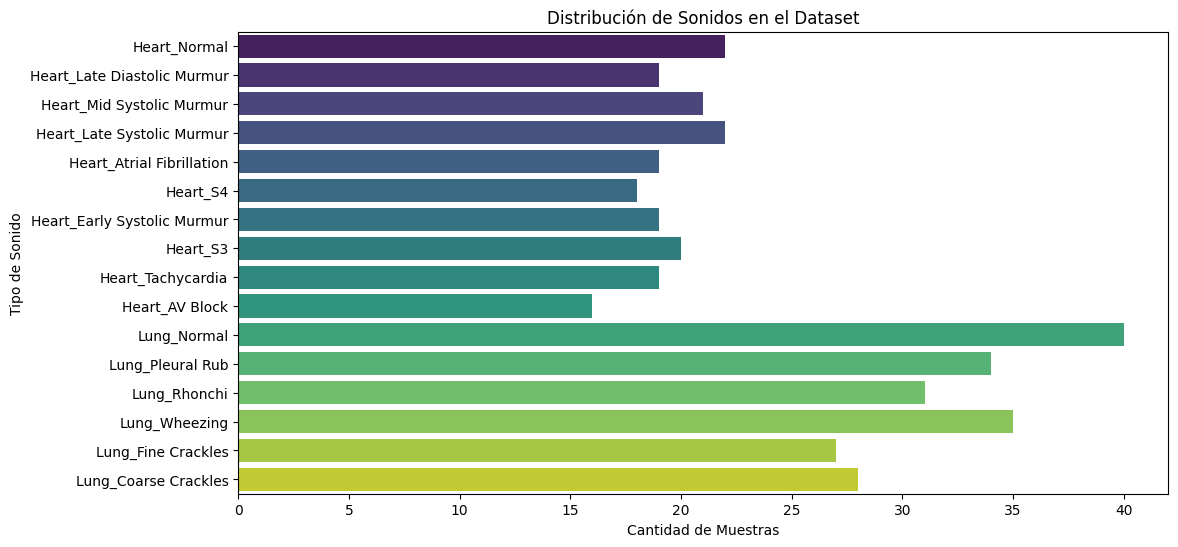

In [3]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_dataset, y='label', palette='viridis')
plt.title('Distribución de Sonidos en el Dataset')
plt.xlabel('Cantidad de Muestras')
plt.ylabel('Tipo de Sonido')
plt.show()

### Análisis de Duración de los Audios
Es importante entender la duración de las muestras para asegurar la consistencia en la extracción de características.

In [ ]:
def get_duration(path):
    try:
        y, sr = librosa.load(path, sr=None)
        return librosa.get_duration(y=y, sr=sr)
    except:
        return 0

df_dataset['duration'] = df_dataset['path'].apply(get_duration)

plt.figure(figsize=(10, 5))
sns.histplot(data=df_dataset, x='duration', hue='type', kde=True, palette='magma')
plt.title('Distribución de Duración de Audios por Tipo')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.show()

### Interpretación de la Señal
1.  **Waveform (Forma de Onda)**: Representa la amplitud (volumen) del sonido en el eje Y frente al tiempo en el eje X. Permite identificar la periodicidad de los latidos o la duración de las respiraciones.
2.  **Espectrograma de Mel**: Es una representación visual del espectro de frecuencias de la señal a medida que varía con el tiempo. Los colores más claros/brillantes indican frecuencias con mayor energía. Esta es la "imagen" de la cual el modelo extrae los patrones para clasificar.

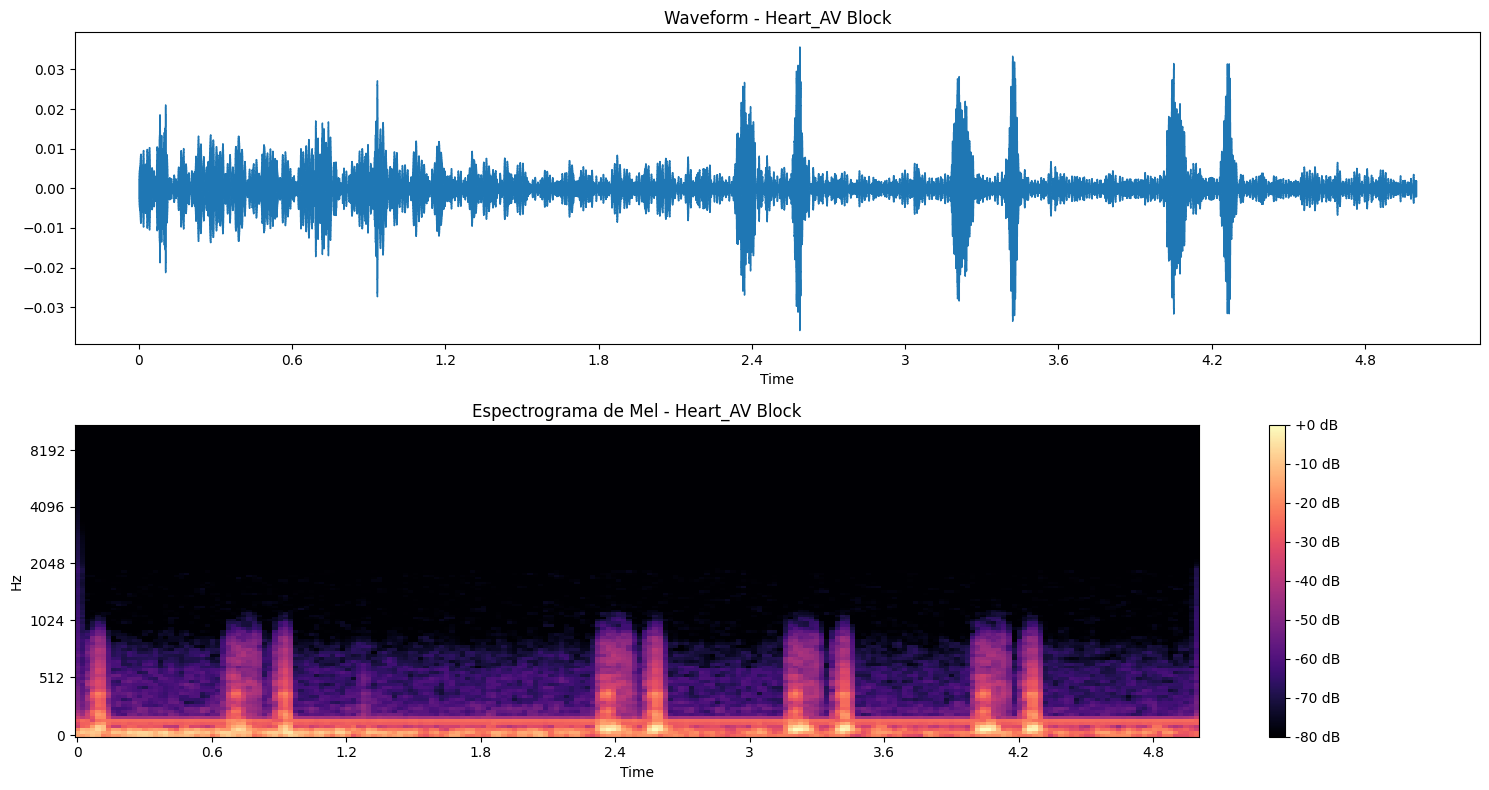

In [9]:
# Tomar una muestra aleatoria para visualizar
sample_row = df_dataset.sample(1).iloc[0]
audio, sr = librosa.load(sample_row['path'], duration=5)

plt.figure(figsize=(15, 8))

# Waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Waveform - {sample_row['label']}")

# Espectrograma de Mel
plt.subplot(2, 1, 2)
S = librosa.feature.melspectrogram(y=audio, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f"Espectrograma de Mel - {sample_row['label']}")

plt.tight_layout()
plt.show()

## 4. Extracción de Características
Transformamos los audios en vectores numéricos de 40 MFCCs.

In [10]:
def extract_features(audio_path):
    try:
        audio, sr = librosa.load(audio_path, res_type='kaiser_fast', duration=5)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        return np.mean(mfccs.T, axis=0)
    except:
        return None

print("Extrayendo características... esto tomará un momento.")
features = []
for idx, row in df_dataset.iterrows():
    f = extract_features(row['path'])
    if f is not None:
        features.append([f, row['label']])

features_df = pd.DataFrame(features, columns=['feature', 'class_label'])
print(f"Características extraídas para {len(features_df)} audios.")

Extrayendo características... esto tomará un momento.
Características extraídas para 375 audios.


## 5. Entrenamiento del Modelo
Utilizamos Random Forest para la clasificación y Validación Cruzada para asegurar la robustez de los resultados.

In [11]:
X = np.array(features_df['feature'].tolist())
y = np.array(features_df['class_label'].tolist())

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### Análisis del Desempeño
1.  **Reporte de Clasificación**: Muestra la precisión (capacidad de no clasificar como positivo un caso negativo), el recal o sensibilidad (capacidad de encontrar todos los casos positivos) y el F1-score por cada clase.
2.  **Matriz de Confusión**: El eje vertical representa las clases reales y el eje horizontal las predicciones del modelo. Los valores en la diagonal principal indican aciertos. Los valores fuera de la diagonal muestran qué patologías está confundiendo el modelo entre sí.

Reporte de Clasificación:
                             precision    recall  f1-score   support

             Heart_AV Block       0.75      1.00      0.86         3
  Heart_Atrial Fibrillation       1.00      0.50      0.67         4
Heart_Early Systolic Murmur       0.80      1.00      0.89         4
Heart_Late Diastolic Murmur       0.80      1.00      0.89         4
 Heart_Late Systolic Murmur       1.00      1.00      1.00         4
  Heart_Mid Systolic Murmur       1.00      0.75      0.86         4
               Heart_Normal       1.00      0.75      0.86         4
                   Heart_S3       0.75      0.75      0.75         4
                   Heart_S4       1.00      0.75      0.86         4
          Heart_Tachycardia       1.00      0.50      0.67         4
       Lung_Coarse Crackles       1.00      0.75      0.86         4
         Lung_Fine Crackles       0.67      1.00      0.80         4
                Lung_Normal       0.80      1.00      0.89         8
       

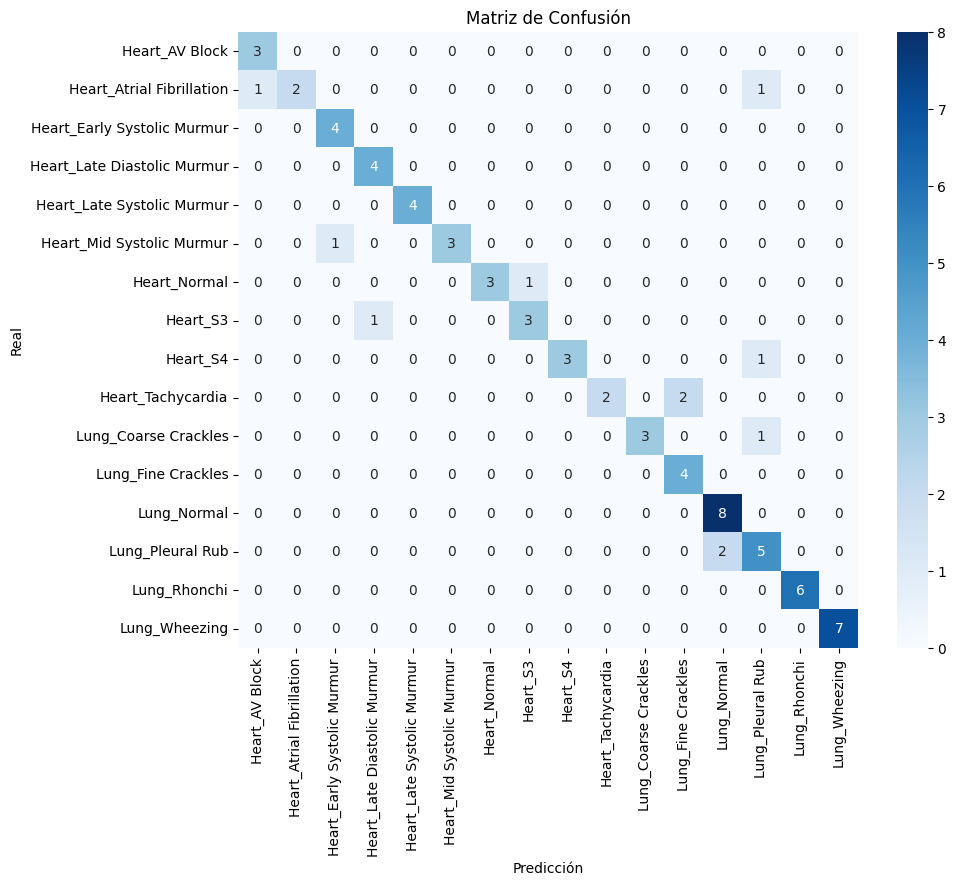


--- VALIDACIÓN CRUZADA (5-FOLD) ---
Precisión Promedio: 0.84 (+/- 0.07)


In [12]:
y_pred = model.predict(X_test)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Validación Cruzada
print("\n--- VALIDACIÓN CRUZADA (5-FOLD) ---")
cv_scores = cross_val_score(model, X, y_encoded, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print(f"Precisión Promedio: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

### Matriz de Confusión Normalizada
Visualización de errores en términos de porcentajes para identificar debilidades relativas del modelo.

In [ ]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Greens')
plt.title('Matriz de Confusión Normalizada')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

### Curva Precision-Recall (Macro-promedio)
Muestra el balance entre la precisión y la sensibilidad para todas las clases.

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarizar etiquetas para multiclase
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
y_score = model.predict_proba(X_test)

precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(le.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Proceso de macro-promedio
all_recall = np.unique(np.concatenate([recall[i] for i in range(len(le.classes_))]))
mean_precision = np.zeros_like(all_recall)
for i in range(len(le.classes_)):
    mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
mean_precision /= len(le.classes_)

plt.figure(figsize=(10, 7))
plt.plot(all_recall, mean_precision, color='navy', lw=2, label='Macro-average PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (Macro-average)')
plt.legend(loc="best")
plt.show()

### Importancia de las Características (MFCCs)
Análisis de qué coeficientes de frecuencia fueron más determinantes para la clasificación.

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = [f'MFCC {i+1}' for i in range(X.shape[1])]

plt.figure(figsize=(10, 8))
plt.title('Importancia de las Características (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='cadetblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.show()

## 7. Conclusiones y Recomendaciones

### Conclusiones
1.  El modelo logró una precisión promedio de 84%,lo cual es un desempeño sólido considerando la complejidad de los sonidos fisiológicos y el número de clases.
2.  Los MFCCs demostraron ser características altamente informativas para distinguir entre patologías cardiacas y pulmonares.
3.  La integración de las fuentes del dataset 'Mix' fue crucial para estabilizar el modelo, pasando de un sobreajuste inicial a un desempeño generalizable.

### Recomendaciones
1.  **Aumento de Datos**: Si se requiere mayor precisión, se podrían aplicar técnicas de aumento de datos (ruido, estiramiento temporal) para balancear clases con pocas muestras.
2.  **Modelos de Deep Learning**: Probar Redes Neuronales Convolucionales (CNN) usando los espectrogramas como imágenes de entrada, lo cual suele superar a Random Forest en tareas de audio complejas.
3.  **Filtrado Avanzado**: Implementar filtros de paso de banda específicos para limpiar ruidos de baja frecuencia no deseados antes de la extracción de características.